# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

In [2]:
#En primera ejecucion descargar paquetes populares ('punkt')
# import nltk
# nltk.download()

In [3]:
dataset = pd.DataFrame(columns=['tag','content'])

with open('datos/SMSSpamCollection.txt',encoding='utf-8') as file:
    content = file.read().split('\n')
    content = content[:-1]
    for row in content:
        row = word_tokenize(row)
        if row[0] == 'spam':
            tag = 0
        elif row[0] == 'ham':
            tag = 1
        dataset = dataset.append({'tag':tag,
                                 'content':row[1:]},ignore_index=True)
        

In [4]:
X = dataset['content']
Y = dataset['tag'].astype('int')

stemmer = nltk.stem.SnowballStemmer('english', ignore_stopwords = True)

swords = stopwords.words('english')

bow = []

for content in X:
    
    stemmed = [stemmer.stem(word) for word in content]
    bow.append(' '.join(stemmed))

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(bow)
bow = bow.toarray()

xtrain, xtest, ytrain, ytest = train_test_split(bow,
                                                Y,
                                                stratify = Y,
                                                test_size=0.2,
                                                random_state=420)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error

#Logistic Reg
logreg = LogisticRegression()
logreg.fit(xtrain,ytrain)
prediction = logreg.predict(xtest)

In [7]:
print(f'Accuracy:\n{accuracy_score(ytest,prediction)}\n\n')
print(f'Confusion Matrix:\n{confusion_matrix(ytest,prediction)}\n\n')
print(f'MSE:\n{mean_squared_error(ytest,prediction)}')
log_acc = accuracy_score(ytest,prediction)
log_mse = mean_squared_error(ytest,prediction)

Accuracy:
0.9829596412556054


Confusion Matrix:
[[131  18]
 [  1 965]]


MSE:
0.017040358744394617


In [8]:
import tensorflow as tf
from tensorflow import keras

In [9]:
#neurons

predictions = []

for i in range(1,11):
    
    model = keras.Sequential()
    
    model.add(keras.layers.Dense(units=i,
                                 activation=tf.nn.relu,
                                 input_dim=xtrain.shape[1]))
    model.add(keras.layers.Dense(units = 1,
                                 activation=tf.nn.sigmoid))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(xtrain,ytrain,epochs=50,batch_size=30,verbose=0)
    
    prediction = model.evaluate(xtest,ytest)
    predictions.append((i,prediction[1]))
    

1115/1115 [==============================] - 0s 220us/sample - loss: 0.1150 - accuracy: 0.9857


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

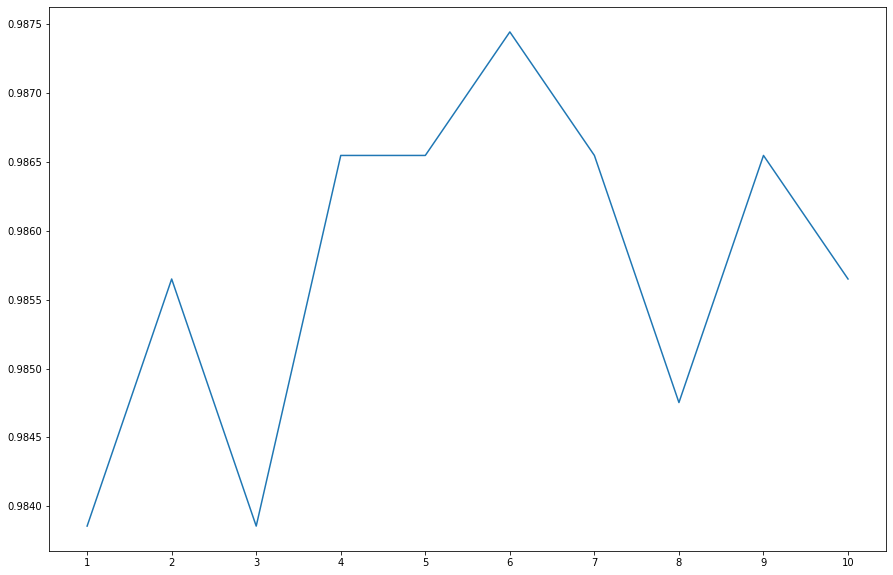

In [11]:
plt.figure(figsize=(15,10))
neurons = []
accuracies = []
for p in predictions:
    neurons.append(p[0])
    accuracies.append(p[1])
plt.xticks(neurons)
plt.plot(neurons,accuracies)
biggest = (predictions[0])
for p in predictions[1:]:
    if p[1] > biggest[1]:
        biggest = p
neurons_per_layer = biggest[0]

In [12]:
#layers

layer_pred = []

for i in range(1,11):
    
    model = keras.Sequential()
    
    for j in range(0,i):
        
        model.add(keras.layers.Dense(units=neurons_per_layer,
                                     activation = tf.nn.relu,
                                     input_dim = xtrain.shape[1]))
    
    model.add(keras.layers.Dense(units=1,
                                 activation = tf.nn.sigmoid))
    
    model.compile(optimizer='adam',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(xtrain,ytrain,epochs=50,batch_size=30,verbose=0)
    prediction = model.evaluate(xtest,ytest)
    layer_pred.append((i,prediction[1]))

1115/1115 [==============================] - 0s 363us/sample - loss: 0.2325 - accuracy: 0.9839


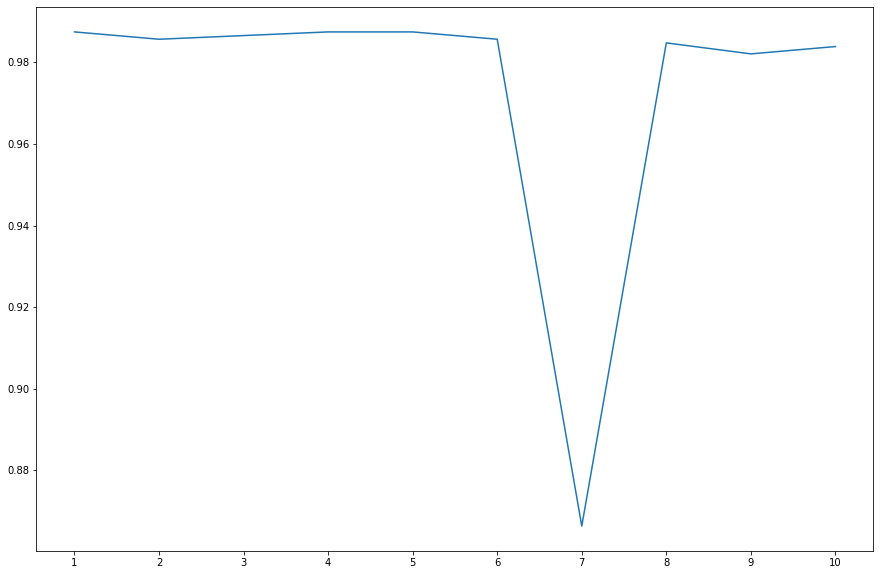

In [13]:
plt.figure(figsize=(15,10))
layers = []
accuracies = []
for p in layer_pred:
    layers.append(p[0])
    accuracies.append(p[1])
plt.xticks(layers)
plt.plot(layers,accuracies)
biggest = layer_pred[0]
for p in layer_pred[1:]:
    if p[1] > biggest[1]:
        biggest = p
number_layers=biggest[0]

In [14]:
print(f'Number of neurons per layer {neurons_per_layer}')
print(f'Number of layers {number_layers}')

Number of neurons per layer 6
Number of layers 1


In [15]:
#final model

model = keras.Sequential()

for i in range(0,number_layers):
    model.add(keras.layers.Dense(units = neurons_per_layer,
                                 activation = tf.nn.relu,
                                 input_dim = xtrain.shape[1]))

model.add(keras.layers.Dense(units = 1,
                             activation = tf.nn.sigmoid))

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(xtrain,ytrain,epochs=50,batch_size=30,verbose=0)
prediction = model.evaluate(xtest,ytest)

1115/1115 [==============================] - 0s 271us/sample - loss: 0.1017 - accuracy: 0.9865


In [16]:
print('Accuracy for NN:',round(prediction[1],3))

Accuracy for NN: 0.987


In [17]:
from sklearn.model_selection import KFold

In [18]:
#Cross validation



def x_validation(train_index,test_index,X,Y):
    
    xtrain = X[train_index]
    xtest = X[test_index]
    ytrain = Y.iloc[train_index]
    ytest = Y.iloc[test_index]
    
    model = keras.Sequential()
    
    for i in range(0,number_layers):
        model.add(keras.layers.Dense(units = neurons_per_layer,
                                     activation = tf.nn.relu,
                                     input_dim = xtrain.shape[1]))
    
    model.add(keras.layers.Dense(units = 1,
                                 activation = tf.nn.sigmoid))
    
    model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy', 'mse'])
    
    model.fit(xtrain,ytrain,epochs = 50, batch_size = 30, verbose = 0)
    prediction = model.evaluate(xtest,ytest)
    
    return prediction

fk = KFold(n_splits=4)

predictions = []

for train_index, test_index in fk.split(xtrain):
    predictions.append(x_validation(train_index,test_index,xtrain,ytrain))

1114/1114 [==============================] - 0s 247us/sample - loss: 0.0801 - accuracy: 0.9847 - mse: 0.0133


In [19]:
acc = []
mse = []
for p in predictions:
    acc.append(p[1])
    mse.append(p[2])

print('Regresion logistica:\n-----------------------')
print('Precision regresion logistica:',round(log_acc,3))
print('Error Media Cuadrada regresion logistica:',round(log_mse,3))
print('\nValidacion cruzada:\n-----------------------')
print('Precision promedio del modelo:',
     round(sum(acc)/len(acc),3))
print('Error Media Cuadrada promedio del modelo:',
     round(sum(mse)/len(mse),3))

Regresion logistica:
-----------------------
Precision regresion logistica: 0.983
Error Media Cuadrada regresion logistica: 0.017

Validacion cruzada:
-----------------------
Precision promedio del modelo: 0.984
Error Media Cuadrada promedio del modelo: 0.014
